In [1]:
import veloxchem as vlx
import numpy as np
import py3Dmol as p3d

In [2]:
# molecule and basis

mol_xyz = """12
c2h4-dimer
C         -1.37731        1.01769       -0.71611
C         -0.04211        1.07142       -0.72602
H         -1.96225        1.74636       -0.16458
H         -1.90859        0.23094       -1.24174
H          0.49049        1.84498       -0.18262
H          0.54315        0.32947       -1.25941
C         -1.17537       -1.48468        2.37427
C          0.06813       -1.06658        2.62697
H         -1.35657       -2.40378        1.82687
H          0.92893       -1.63558        2.29127
H         -2.03527       -0.90348        2.69157
H          0.24803       -0.13578        3.15527
"""
molecule = vlx.Molecule.read_xyz_string(mol_xyz)
basis = vlx.MolecularBasis.read(molecule, 'def2-svp')

In [3]:
viewer = p3d.view(viewergrid=(1,1),width=300,height=300)
viewer.addModel(mol_xyz, 'xyz', viewer=(0,0))
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(90,'x')
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
# exciton model setup
exmod_settings = {
    'fragments': '2',
    'atoms_per_fragment': '6',
    'charges': '0',
    'nstates': '5',
    'ct_nocc': '1',
    'ct_nvir': '1',
}

method_settings = {'dft': 'no'}
exmod_drv = vlx.ExcitonModelDriver()
exmod_drv.update_settings(exmod_settings, method_settings)

In [5]:
monomer_natoms = list(exmod_drv.natoms)
n_monomers = len(monomer_natoms)
monomer_start_indices = [sum(exmod_drv.natoms[:i]) for i in range(n_monomers)]

npairs = n_monomers * (n_monomers - 1) // 2
total_LE_states = n_monomers * exmod_drv.nstates
total_CT_states = npairs * exmod_drv.ct_nocc * exmod_drv.ct_nvir * 2
total_num_states = total_LE_states + total_CT_states

exmod_drv.H = np.zeros((total_num_states, total_num_states))
exmod_drv.elec_trans_dipoles = np.zeros((total_num_states, 3))
exmod_drv.velo_trans_dipoles = np.zeros((total_num_states, 3))
exmod_drv.magn_trans_dipoles = np.zeros((total_num_states, 3))
exmod_drv.center_of_mass = molecule.center_of_mass_in_bohr()

state_strings = ['' for s in range(total_num_states)]

dimer_pairs = [(indA, indB)
               for indA in range(n_monomers)
               for indB in range(indA + 1, n_monomers)]
excitation_ids = exmod_drv.get_excitation_ids(dimer_pairs)

In [6]:
# monomer calculations

monomers_info = [{} for ind in range(n_monomers)]

for ind in range(n_monomers):
    atomlist = list(range(monomer_start_indices[ind],
                          monomer_start_indices[ind] + monomer_natoms[ind]))
    monomer = molecule.slice(atomlist)
    monomer.set_charge(exmod_drv.charges[ind])
    monomer.check_multiplicity()

    monomer_basis = basis.slice(atomlist)

    scf_tensors = exmod_drv.monomer_scf(method_settings, ind, monomer, monomer_basis)
    tda_results = exmod_drv.monomer_tda(method_settings, ind, monomer, monomer_basis,
                                        scf_tensors)

    monomers_info[ind]['mo'] = scf_tensors['C_alpha']
    monomers_info[ind]['exc_energies'] = tda_results['exc_energies']
    monomers_info[ind]['exc_vectors'] = tda_results['exc_vectors']

    one_elec_ints = exmod_drv.get_one_elec_integrals(monomer, monomer_basis)
    trans_dipoles = exmod_drv.get_LE_trans_dipoles(monomer, monomer_basis,
                                                   one_elec_ints, scf_tensors,
                                                   tda_results)

    # LE states
    for s in range(exmod_drv.nstates):
        h = excitation_ids[ind, ind] + s
        # LE energies
        exmod_drv.H[h, h] = monomers_info[ind]['exc_energies'][s]
        # LE transition dipoles
        exmod_drv.elec_trans_dipoles[h, :] = trans_dipoles['electric'][s]
        exmod_drv.velo_trans_dipoles[h, :] = trans_dipoles['velocity'][s]
        exmod_drv.magn_trans_dipoles[h, :] = trans_dipoles['magnetic'][s]

                                              Molecular Geometry (Angstroms)                                              
                                                                                                                          
                          Atom         Coordinate X          Coordinate Y          Coordinate Z                           
                                                                                                                          
                           C          -1.377310000000        1.017690000000       -0.716110000000                         
                           C          -0.042110000000        1.071420000000       -0.726020000000                         
                           H          -1.962250000000        1.746360000000       -0.164580000000                         
                           H          -1.908590000000        0.230940000000       -1.241740000000                         
                

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 150                                                                  
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -77.938957127732 a.u. Time: 0.09 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.00 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -77.976557123996    0.0000000000      0.09489888      0.01290528      0.00000000                


                  2       -77.977520078787   -0.0009629548      0.01398453      0.00235274      0.02938556                


                  3       -77.977544421755   -0.0000243430      0.00352086      0.00057093      0.00470842                


                  4       -77.977546548111   -0.0000021264      0.00046203      0.00007456      0.00153235                


                  5       -77.977546603605   -0.0000000555      0.00006899      0.00001360      0.00033144                


                  6       -77.977546605077   -0.0000000015      0.00001040      0.00000219      0.00006395                


                  7       -77.977546605109   -0.0000000000      0.00000091      0.00000011      0.00000951                


                                                                                                                          
               *** SCF converged in 7 iterations. Time: 0.49 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -77.9775466051 a.u.                                              
               Electronic Energy                  :     -111.2973765222 a.u.                                              
               Nuclear Repulsion Energy           :       33.3198299171 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000009100 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :         0.000410 a.u.         0.001042 Debye                                     
                                   Y   :        -0.007578 a.u.        -0.019260 Debye                                     
                                   Z   :         0.010687 a.u.         0.027164 Debye                                     
                                 Total :         0.013108 a.u.         0.033316 Debye                                     
                

                                                                                                                          
                                                     TDA Driver Setup                                                     
                                                                                                                          
                               Number of States                : 5                                                        
                               Max. Number of Iterations       : 100                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                                                                                                                          


                   *** Iteration:   1 * Reduced Space:    5 * Residues (Max,Min): 2.13e-01 and 6.34e-02                   
                                                                                                                          
                   State  1: 0.34776432 a.u. Residual Norm: 0.06411031                                                    
                   State  2: 0.35563977 a.u. Residual Norm: 0.08504656                                                    
                   State  3: 0.35615247 a.u. Residual Norm: 0.21331548                                                    
                   State  4: 0.36532189 a.u. Residual Norm: 0.07855063                                                    
                   State  5: 0.39640597 a.u. Residual Norm: 0.06336656                                                    
                                                                                                                          


                   *** Iteration:   2 * Reduced Space:   10 * Residues (Max,Min): 3.72e-02 and 9.22e-03                   
                                                                                                                          
                   State  1: 0.31097350 a.u. Residual Norm: 0.03718790                                                    
                   State  2: 0.34145869 a.u. Residual Norm: 0.01285025                                                    
                   State  3: 0.34478340 a.u. Residual Norm: 0.01055905                                                    
                   State  4: 0.35566831 a.u. Residual Norm: 0.00921706                                                    
                   State  5: 0.39016820 a.u. Residual Norm: 0.01267175                                                    
                                                                                                                          


                   *** Iteration:   3 * Reduced Space:   15 * Residues (Max,Min): 6.02e-02 and 1.94e-03                   
                                                                                                                          
                   State  1: 0.30903317 a.u. Residual Norm: 0.00798914                                                    
                   State  2: 0.34134501 a.u. Residual Norm: 0.00248600                                                    
                   State  3: 0.34465110 a.u. Residual Norm: 0.00201592                                                    
                   State  4: 0.35557423 a.u. Residual Norm: 0.00194324                                                    
                   State  5: 0.38822946 a.u. Residual Norm: 0.06022102                                                    
                                                                                                                          


                   *** Iteration:   4 * Reduced Space:   20 * Residues (Max,Min): 3.30e-02 and 1.24e-04                   
                                                                                                                          
                   State  1: 0.30897493 a.u. Residual Norm: 0.00322653                                                    
                   State  2: 0.34133733 a.u. Residual Norm: 0.00047385                                                    
                   State  3: 0.34464900 a.u. Residual Norm: 0.00012369                                                    
                   State  4: 0.35557238 a.u. Residual Norm: 0.00013703                                                    
                   State  5: 0.37684228 a.u. Residual Norm: 0.03299540                                                    
                                                                                                                          


                   *** Iteration:   5 * Reduced Space:   25 * Residues (Max,Min): 1.29e-02 and 5.35e-05                   
                                                                                                                          
                   State  1: 0.30897029 a.u. Residual Norm: 0.00084213                                                    
                   State  2: 0.34133726 a.u. Residual Norm: 0.00011005                                                    
                   State  3: 0.34464896 a.u. Residual Norm: 0.00007201                                                    
                   State  4: 0.35557236 a.u. Residual Norm: 0.00005346                                                    
                   State  5: 0.37565302 a.u. Residual Norm: 0.01293763                                                    
                                                                                                                          


                   *** Iteration:   6 * Reduced Space:   30 * Residues (Max,Min): 5.13e-03 and 7.94e-06                   
                                                                                                                          
                   State  1: 0.30897008 a.u. Residual Norm: 0.00010760                                                    
                   State  2: 0.34133726 a.u. Residual Norm: 0.00002105                                                    
                   State  3: 0.34464896 a.u. Residual Norm: 0.00001287                                                    
                   State  4: 0.35557235 a.u. Residual Norm: 0.00000794                                                    
                   State  5: 0.37556970 a.u. Residual Norm: 0.00512962                                                    
                                                                                                                          


                   *** Iteration:   7 * Reduced Space:   35 * Residues (Max,Min): 6.12e-04 and 8.41e-07                   
                                                                                                                          
                   State  1: 0.30897008 a.u. Residual Norm: 0.00001205                                                    
                   State  2: 0.34133725 a.u. Residual Norm: 0.00000319                                                    
                   State  3: 0.34464896 a.u. Residual Norm: 0.00000114                                                    
                   State  4: 0.35557235 a.u. Residual Norm: 0.00000084                                                    
                   State  5: 0.37556218 a.u. Residual Norm: 0.00061208                                                    
                                                                                                                          


                   *** Iteration:   8 * Reduced Space:   40 * Residues (Max,Min): 1.05e-04 and 3.30e-07                   
                                                                                                                          
                   State  1: 0.30897008 a.u. Residual Norm: 0.00000130                                                    
                   State  2: 0.34133725 a.u. Residual Norm: 0.00000073                                                    
                   State  3: 0.34464896 a.u. Residual Norm: 0.00000033                                                    
                   State  4: 0.35557235 a.u. Residual Norm: 0.00000050                                                    
                   State  5: 0.37556201 a.u. Residual Norm: 0.00010481                                                    
                                                                                                                          


                   *** Iteration:   9 * Reduced Space:   45 * Residues (Max,Min): 1.65e-05 and 1.20e-07                   
                                                                                                                          
                   State  1: 0.30897008 a.u. Residual Norm: 0.00000027                                                    
                   State  2: 0.34133725 a.u. Residual Norm: 0.00000012                                                    
                   State  3: 0.34464896 a.u. Residual Norm: 0.00000012                                                    
                   State  4: 0.35557235 a.u. Residual Norm: 0.00000017                                                    
                   State  5: 0.37556201 a.u. Residual Norm: 0.00001655                                                    
                                                                                                                          


               *** 5 excited states converged in 9 iterations. Time: 3.13 sec                                             
                                                                                                                          
                                                                                                                          


               Electric Transition Dipole Moments (dipole length, a.u.)                                                   
               --------------------------------------------------------                                                   
                                                X            Y            Z                                               
               Excited State    S1:     -1.751428    -0.070624     0.013099                                               
               Excited State    S2:      0.004893    -0.101652     0.143186                                               
               Excited State    S3:      0.000404    -0.005778    -0.005701                                               
               Excited State    S4:      0.001038    -0.004353    -0.002742                                               
               Excited State    S5:      0.013278     0.000576    -0.000132                                               
                

               Electric Transition Dipole Moments (dipole velocity, a.u.)                                                 
               ----------------------------------------------------------                                                 
                                                X            Y            Z                                               
               Excited State    S1:     -0.874293    -0.035219     0.006413                                               
               Excited State    S2:      0.008190    -0.164623     0.231994                                               
               Excited State    S3:      0.000168    -0.003183    -0.004934                                               
               Excited State    S4:      0.000697    -0.003958    -0.002264                                               
               Excited State    S5:      0.007697     0.000362    -0.000050                                               
                

               Magnetic Transition Dipole Moments (a.u.)                                                                  
               -----------------------------------------                                                                  
                                                X            Y            Z                                               
               Excited State    S1:     -0.005420     0.177719     0.268587                                               
               Excited State    S2:      0.035857     0.050997     0.035103                                               
               Excited State    S3:     -0.588993    -0.024477     0.005151                                               
               Excited State    S4:     -0.405248    -0.016471     0.003944                                               
               Excited State    S5:      0.022746    -0.663428    -0.472983                                               
                

               One-Photon Absorption                                                                                      
               ---------------------                                                                                      
               Excited State    S1:      0.30897008 a.u.      8.40750 eV    Osc.Str.    0.6329                            
               Excited State    S2:      0.34133725 a.u.      9.28826 eV    Osc.Str.    0.0070                            
               Excited State    S3:      0.34464896 a.u.      9.37838 eV    Osc.Str.    0.0000                            
               Excited State    S4:      0.35557235 a.u.      9.67562 eV    Osc.Str.    0.0000                            
               Excited State    S5:      0.37556201 a.u.     10.21956 eV    Osc.Str.    0.0000                            
                                                                                                                          


               Electronic Circular Dichroism                                                                              
               -----------------------------                                                                              
               Excited State    S1:     Rot.Str.      0.000202 a.u.     0.0953 [10**(-40) cgs]                            
               Excited State    S2:     Rot.Str.      0.000042 a.u.     0.0198 [10**(-40) cgs]                            
               Excited State    S3:     Rot.Str.     -0.000047 a.u.    -0.0220 [10**(-40) cgs]                            
               Excited State    S4:     Rot.Str.     -0.000226 a.u.    -0.1066 [10**(-40) cgs]                            
               Excited State    S5:     Rot.Str.     -0.000041 a.u.    -0.0194 [10**(-40) cgs]                            
                                                                                                                          


               Character of excitations:                                                                                  
                                                                                                                          
               Excited state 1                                                                                            
               ---------------                                                                                            
               HOMO     -> LUMO        -0.9680                                                                            
                                                                                                                          
               Excited state 2                                                                                            
               ---------------                                                                                            
               H

                                              Molecular Geometry (Angstroms)                                              
                                                                                                                          
                          Atom         Coordinate X          Coordinate Y          Coordinate Z                           
                                                                                                                          
                           C          -1.175370000000       -1.484680000000        2.374270000000                         
                           C           0.068130000000       -1.066580000000        2.626970000000                         
                           H          -1.356570000000       -2.403780000000        1.826870000000                         
                           H           0.928930000000       -1.635580000000        2.291270000000                         
                

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 150                                                                  
                   Max. Number of Error Vectors    : 10                                                                   
                

* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Starting Reduced Basis SCF calculation...                                                                        
* Info * ...done. SCF energy in reduced basis set: -77.938962719117 a.u. Time: 0.10 sec.                                  
                                                                                                                          


* Info * Overlap matrix computed in 0.01 sec.                                                                             
                                                                                                                          
* Info * Kinetic energy matrix computed in 0.00 sec.                                                                      
                                                                                                                          
* Info * Nuclear potential matrix computed in 0.00 sec.                                                                   
                                                                                                                          


* Info * Orthogonalization matrix computed in 0.00 sec.                                                                   
                                                                                                                          


                                                                                                                          
               Iter. | Hartree-Fock Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               
                  1       -77.976569083369    0.0000000000      0.09490689      0.01290816      0.00000000                


                  2       -77.977532245423   -0.0009631621      0.01399502      0.00231192      0.02939863                


                  3       -77.977556624827   -0.0000243794      0.00352284      0.00057127      0.00471110                


                  4       -77.977558753783   -0.0000021290      0.00046240      0.00007460      0.00153316                


                  5       -77.977558809364   -0.0000000556      0.00006906      0.00001361      0.00033156                


                  6       -77.977558810840   -0.0000000015      0.00001041      0.00000219      0.00006400                


                  7       -77.977558810872   -0.0000000000      0.00000094      0.00000011      0.00000952                


                                                                                                                          
               *** SCF converged in 7 iterations. Time: 0.58 sec.                                                         
                                                                                                                          


               Spin-Restricted Hartree-Fock:                                                                              
               -----------------------------                                                                              
               Total Energy                       :      -77.9775588109 a.u.                                              
               Electronic Energy                  :     -111.2999784521 a.u.                                              
               Nuclear Repulsion Energy           :       33.3224196412 a.u.                                              
               ------------------------------------                                                                       
               Gradient Norm                      :        0.0000009393 a.u.                                              
                                                                                                                          
                

                                                                                                                          
                                                Ground State Dipole Moment                                                
                                               ----------------------------                                               
                                                                                                                          
                                   X   :         0.000085 a.u.         0.000216 Debye                                     
                                   Y   :         0.006529 a.u.         0.016594 Debye                                     
                                   Z   :        -0.011293 a.u.        -0.028704 Debye                                     
                                 Total :         0.013044 a.u.         0.033156 Debye                                     
                

                                                                                                                          
                                                     TDA Driver Setup                                                     
                                                                                                                          
                               Number of States                : 5                                                        
                               Max. Number of Iterations       : 100                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Threshold         : 1.0e-12                                                  
                                                                                                                          


                   *** Iteration:   1 * Reduced Space:    5 * Residues (Max,Min): 2.13e-01 and 6.34e-02                   
                                                                                                                          
                   State  1: 0.34783116 a.u. Residual Norm: 0.06412244                                                    
                   State  2: 0.35563877 a.u. Residual Norm: 0.08503436                                                    
                   State  3: 0.35624616 a.u. Residual Norm: 0.21329400                                                    
                   State  4: 0.36533374 a.u. Residual Norm: 0.07855921                                                    
                   State  5: 0.39646091 a.u. Residual Norm: 0.06337301                                                    
                                                                                                                          


                   *** Iteration:   2 * Reduced Space:   10 * Residues (Max,Min): 3.72e-02 and 9.21e-03                   
                                                                                                                          
                   State  1: 0.31108179 a.u. Residual Norm: 0.03718485                                                    
                   State  2: 0.34152241 a.u. Residual Norm: 0.01285172                                                    
                   State  3: 0.34478504 a.u. Residual Norm: 0.01056213                                                    
                   State  4: 0.35567255 a.u. Residual Norm: 0.00921130                                                    
                   State  5: 0.39022130 a.u. Residual Norm: 0.01267120                                                    
                                                                                                                          


                   *** Iteration:   3 * Reduced Space:   15 * Residues (Max,Min): 6.01e-02 and 1.94e-03                   
                                                                                                                          
                   State  1: 0.30914159 a.u. Residual Norm: 0.00799112                                                    
                   State  2: 0.34140869 a.u. Residual Norm: 0.00248645                                                    
                   State  3: 0.34465274 a.u. Residual Norm: 0.00201444                                                    
                   State  4: 0.35557853 a.u. Residual Norm: 0.00194458                                                    
                   State  5: 0.38828574 a.u. Residual Norm: 0.06012338                                                    
                                                                                                                          


                   *** Iteration:   4 * Reduced Space:   20 * Residues (Max,Min): 3.29e-02 and 1.24e-04                   
                                                                                                                          
                   State  1: 0.30908321 a.u. Residual Norm: 0.00323357                                                    
                   State  2: 0.34140101 a.u. Residual Norm: 0.00047406                                                    
                   State  3: 0.34465065 a.u. Residual Norm: 0.00012395                                                    
                   State  4: 0.35557668 a.u. Residual Norm: 0.00013733                                                    
                   State  5: 0.37695764 a.u. Residual Norm: 0.03290224                                                    
                                                                                                                          


                   *** Iteration:   5 * Reduced Space:   25 * Residues (Max,Min): 1.29e-02 and 5.35e-05                   
                                                                                                                          
                   State  1: 0.30907855 a.u. Residual Norm: 0.00084350                                                    
                   State  2: 0.34140093 a.u. Residual Norm: 0.00011023                                                    
                   State  3: 0.34465061 a.u. Residual Norm: 0.00007207                                                    
                   State  4: 0.35557665 a.u. Residual Norm: 0.00005353                                                    
                   State  5: 0.37577701 a.u. Residual Norm: 0.01289342                                                    
                                                                                                                          


                   *** Iteration:   6 * Reduced Space:   30 * Residues (Max,Min): 5.11e-03 and 8.02e-06                   
                                                                                                                          
                   State  1: 0.30907834 a.u. Residual Norm: 0.00010769                                                    
                   State  2: 0.34140093 a.u. Residual Norm: 0.00002109                                                    
                   State  3: 0.34465060 a.u. Residual Norm: 0.00001291                                                    
                   State  4: 0.35557665 a.u. Residual Norm: 0.00000802                                                    
                   State  5: 0.37569441 a.u. Residual Norm: 0.00510829                                                    
                                                                                                                          


                   *** Iteration:   7 * Reduced Space:   35 * Residues (Max,Min): 6.12e-04 and 6.03e-07                   
                                                                                                                          
                   State  1: 0.30907834 a.u. Residual Norm: 0.00001208                                                    
                   State  2: 0.34140093 a.u. Residual Norm: 0.00000320                                                    
                   State  3: 0.34465060 a.u. Residual Norm: 0.00000104                                                    
                   State  4: 0.35557665 a.u. Residual Norm: 0.00000060                                                    
                   State  5: 0.37568693 a.u. Residual Norm: 0.00061164                                                    
                                                                                                                          


                   *** Iteration:   8 * Reduced Space:   40 * Residues (Max,Min): 1.06e-04 and 1.56e-07                   
                                                                                                                          
                   State  1: 0.30907834 a.u. Residual Norm: 0.00000134                                                    
                   State  2: 0.34140093 a.u. Residual Norm: 0.00000074                                                    
                   State  3: 0.34465060 a.u. Residual Norm: 0.00000016                                                    
                   State  4: 0.35557665 a.u. Residual Norm: 0.00000022                                                    
                   State  5: 0.37568677 a.u. Residual Norm: 0.00010635                                                    
                                                                                                                          


                   *** Iteration:   9 * Reduced Space:   45 * Residues (Max,Min): 2.38e-05 and 5.62e-08                   
                                                                                                                          
                   State  1: 0.30907834 a.u. Residual Norm: 0.00000038                                                    
                   State  2: 0.34140093 a.u. Residual Norm: 0.00000020                                                    
                   State  3: 0.34465060 a.u. Residual Norm: 0.00000006                                                    
                   State  4: 0.35557665 a.u. Residual Norm: 0.00000010                                                    
                   State  5: 0.37568676 a.u. Residual Norm: 0.00002378                                                    
                                                                                                                          


               *** 5 excited states converged in 9 iterations. Time: 3.28 sec                                             
                                                                                                                          
                                                                                                                          


               Electric Transition Dipole Moments (dipole length, a.u.)                                                   
               --------------------------------------------------------                                                   
                                                X            Y            Z                                               
               Excited State    S1:     -1.631494    -0.548438    -0.331528                                               
               Excited State    S2:     -0.001132    -0.088161     0.151817                                               
               Excited State    S3:      0.002738    -0.004884    -0.006561                                               
               Excited State    S4:      0.001021    -0.004831    -0.001875                                               
               Excited State    S5:      0.012241     0.004106     0.002480                                               
                

               Electric Transition Dipole Moments (dipole velocity, a.u.)                                                 
               ----------------------------------------------------------                                                 
                                                X            Y            Z                                               
               Excited State    S1:     -0.814914    -0.273886    -0.165526                                               
               Excited State    S2:     -0.001951    -0.142769     0.246050                                               
               Excited State    S3:      0.001953    -0.001675    -0.007254                                               
               Excited State    S4:      0.001115    -0.004417    -0.001220                                               
               Excited State    S5:      0.007104     0.002345     0.001426                                               
                

               Magnetic Transition Dipole Moments (a.u.)                                                                  
               -----------------------------------------                                                                  
                                                X            Y            Z                                               
               Excited State    S1:      0.258067    -0.614366    -0.255234                                               
               Excited State    S2:      0.023319     0.045429     0.026723                                               
               Excited State    S3:      0.550911     0.184525     0.112430                                               
               Excited State    S4:      0.379258     0.127485     0.077885                                               
               Excited State    S5:     -0.299873     0.660489     0.379546                                               
                

               One-Photon Absorption                                                                                      
               ---------------------                                                                                      
               Excited State    S1:      0.30907834 a.u.      8.41045 eV    Osc.Str.    0.6331                            
               Excited State    S2:      0.34140093 a.u.      9.28999 eV    Osc.Str.    0.0070                            
               Excited State    S3:      0.34465060 a.u.      9.37842 eV    Osc.Str.    0.0000                            
               Excited State    S4:      0.35557665 a.u.      9.67573 eV    Osc.Str.    0.0000                            
               Excited State    S5:      0.37568676 a.u.     10.22296 eV    Osc.Str.    0.0000                            
                                                                                                                          


               Electronic Circular Dichroism                                                                              
               -----------------------------                                                                              
               Excited State    S1:     Rot.Str.      0.000212 a.u.     0.0999 [10**(-40) cgs]                            
               Excited State    S2:     Rot.Str.      0.000044 a.u.     0.0207 [10**(-40) cgs]                            
               Excited State    S3:     Rot.Str.     -0.000049 a.u.    -0.0231 [10**(-40) cgs]                            
               Excited State    S4:     Rot.Str.     -0.000235 a.u.    -0.1108 [10**(-40) cgs]                            
               Excited State    S5:     Rot.Str.     -0.000040 a.u.    -0.0188 [10**(-40) cgs]                            
                                                                                                                          


               Character of excitations:                                                                                  
                                                                                                                          
               Excited state 1                                                                                            
               ---------------                                                                                            
               HOMO     -> LUMO        -0.9680                                                                            
                                                                                                                          
               Excited state 2                                                                                            
               ---------------                                                                                            
               H

In [7]:
# dimer calculations

for ind_A in range(n_monomers):
    atomlist_A = list(range(monomer_start_indices[ind_A],
                            monomer_start_indices[ind_A] + monomer_natoms[ind_A]))
    monomer_A = molecule.slice(atomlist_A)
    monomer_A.set_charge(exmod_drv.charges[ind_A])
    monomer_A.check_multiplicity()

    monomer_basis_A = basis.slice(atomlist_A)

    for ind_B in range(ind_A + 1, n_monomers):
        atomlist_B = list(range(monomer_start_indices[ind_B],
                                monomer_start_indices[ind_B] + monomer_natoms[ind_B]))
        monomer_B = molecule.slice(atomlist_B)
        monomer_B.set_charge(exmod_drv.charges[ind_B])
        monomer_B.check_multiplicity()

        monomer_basis_B = basis.slice(atomlist_B)

        dimer = vlx.Molecule(monomer_A, monomer_B)
        dimer.check_multiplicity()

        dimer_basis = basis.slice(atomlist_A + atomlist_B)

        mo_A = monomers_info[ind_A]['mo']
        mo_B = monomers_info[ind_B]['mo']

        nocc_A = monomer_A.number_of_alpha_electrons()
        nocc_B = monomer_B.number_of_alpha_electrons()
        nvir_A = mo_A.shape[1] - nocc_A
        nvir_B = mo_B.shape[1] - nocc_B

        nocc = nocc_A + nocc_B
        nvir = nvir_A + nvir_B

        mo = exmod_drv.dimer_mo_coefficients(monomer_A, monomer_B, monomer_basis_A,
                                             monomer_basis_B, mo_A, mo_B)

        dimer_prop = exmod_drv.dimer_properties(dimer, dimer_basis, mo)

        dimer_energy = dimer_prop['energy']

        exc_vectors_A = monomers_info[ind_A]['exc_vectors']
        exc_vectors_B = monomers_info[ind_B]['exc_vectors']

        exc_vectors = []

        exc_vectors += exmod_drv.dimer_excitation_vectors_LE_A(
            exc_vectors_A, ind_A, nocc_A, nvir_A, nocc, nvir, excitation_ids)

        exc_vectors += exmod_drv.dimer_excitation_vectors_LE_B(
            exc_vectors_B, ind_B, nocc_A, nvir_A, nocc, nvir, excitation_ids)

        exc_vectors += exmod_drv.dimer_excitation_vectors_CT_AB(
            ind_A, ind_B, nocc_A, nvir_A, nocc, nvir, excitation_ids)

        exc_vectors += exmod_drv.dimer_excitation_vectors_CT_BA(
            ind_A, ind_B, nocc_A, nvir_A, nocc, nvir, excitation_ids)

        for c_vec in exc_vectors:
            state_strings[c_vec['index']] = c_vec['type'] + '(' + c_vec['frag'] + ')'
            state_strings[c_vec['index']] += '   ' + c_vec['name']

        sigma_vectors = exmod_drv.dimer_sigma_vectors(dimer, dimer_basis, dimer_prop,
                                                      mo, exc_vectors)

        one_elec_ints = exmod_drv.get_one_elec_integrals(dimer, dimer_basis)
        trans_dipoles = exmod_drv.get_CT_trans_dipoles(
            dimer, dimer_basis, one_elec_ints, mo,
            exc_vectors[exmod_drv.nstates * 2:])

        # CT states
        for i_vec, (c_vec, s_vec) in enumerate(
                zip(exc_vectors[exmod_drv.nstates * 2:],
                    sigma_vectors[exmod_drv.nstates * 2:])):
            # CT energies
            energy = np.vdot(c_vec['vec'], s_vec['vec'])
            exmod_drv.H[c_vec['index'], c_vec['index']] = energy
            # CT transition dipoles
            exmod_drv.elec_trans_dipoles[
                c_vec['index'], :] = trans_dipoles['electric'][i_vec]
            exmod_drv.velo_trans_dipoles[
                c_vec['index'], :] = trans_dipoles['velocity'][i_vec]
            exmod_drv.magn_trans_dipoles[
                c_vec['index'], :] = trans_dipoles['magnetic'][i_vec]

        # LE(A)-LE(B) couplings
        for c_vec in exc_vectors[:exmod_drv.nstates]:
            for s_vec in sigma_vectors[exmod_drv.nstates:exmod_drv.nstates * 2]:
                coupling = np.vdot(c_vec['vec'], s_vec['vec'])
                exmod_drv.H[c_vec['index'], s_vec['index']] = coupling
                exmod_drv.H[s_vec['index'], c_vec['index']] = coupling

        # LE-CT couplings
        for c_vec in exc_vectors[:exmod_drv.nstates * 2]:
            for s_vec in sigma_vectors[exmod_drv.nstates * 2:]:
                coupling = np.vdot(c_vec['vec'], s_vec['vec'])
                exmod_drv.H[c_vec['index'], s_vec['index']] = coupling
                exmod_drv.H[s_vec['index'], c_vec['index']] = coupling

        # CT-CT couplings
        for c_vec in exc_vectors[exmod_drv.nstates * 2:]:
            for s_vec in sigma_vectors[exmod_drv.nstates * 2:]:
                if c_vec['index'] >= s_vec['index']:
                    continue
                coupling = np.vdot(c_vec['vec'], s_vec['vec'])
                exmod_drv.H[c_vec['index'], s_vec['index']] = coupling
                exmod_drv.H[s_vec['index'], c_vec['index']] = coupling

                                              Molecular Geometry (Angstroms)                                              
                                                                                                                          
                          Atom         Coordinate X          Coordinate Y          Coordinate Z                           
                                                                                                                          
                           C          -1.377310000000        1.017690000000       -0.716110000000                         
                           C          -0.042110000000        1.071420000000       -0.726020000000                         
                           H          -1.962250000000        1.746360000000       -0.164580000000                         
                           H          -1.908590000000        0.230940000000       -1.241740000000                         
                

In [8]:
np.set_printoptions(precision=6, suppress=True)

n = exmod_drv.nstates
H = exmod_drv.H

print('The LE(A)-LE(A) block:\n')
print(H[:n, :n], '\n')

print('The LE(A)-LE(B) block:\n')
print(H[:n, n:n*2], '\n')

print('The LE(A)-CT block:\n')
print(H[:n, n*2:], '\n')

print('The LE(B)-LE(B) block:\n')
print(H[n:n*2, n:n*2], '\n')

print('The LE(B)-CT block:\n')
print(H[n:n*2, n*2:], '\n')

print('The CT-CT block:\n')
print(H[n*2:, n*2:], '\n')

The LE(A)-LE(A) block:

[[0.30897  0.       0.       0.       0.      ]
 [0.       0.341337 0.       0.       0.      ]
 [0.       0.       0.344649 0.       0.      ]
 [0.       0.       0.       0.355572 0.      ]
 [0.       0.       0.       0.       0.375562]] 

The LE(A)-LE(B) block:

[[ 0.008184 -0.000023 -0.00041  -0.000293 -0.001344]
 [ 0.000018  0.000181  0.000039 -0.000038 -0.000004]
 [ 0.000421 -0.000009  0.000136  0.000216 -0.000076]
 [ 0.000301  0.000065  0.000215 -0.000065 -0.000057]
 [-0.001349  0.000005  0.000075  0.000053  0.000226]] 

The LE(A)-CT block:

[[-0.014982  0.021419]
 [-0.00015  -0.00001 ]
 [-0.00193   0.000318]
 [ 0.002297  0.000302]
 [ 0.002587 -0.001974]] 

The LE(B)-LE(B) block:

[[0.309078 0.       0.       0.       0.      ]
 [0.       0.341401 0.       0.       0.      ]
 [0.       0.       0.344651 0.       0.      ]
 [0.       0.       0.       0.355577 0.      ]
 [0.       0.       0.       0.       0.375687]] 

The LE(B)-CT block:

[[ 0.021419 -0

In [9]:
for s, state_str in enumerate(state_strings):
    print(f'diabatic state {s+1:<5d}', state_str)

diabatic state 1     LE(A)   1e(1)
diabatic state 2     LE(A)   1e(2)
diabatic state 3     LE(A)   1e(3)
diabatic state 4     LE(A)   1e(4)
diabatic state 5     LE(A)   1e(5)
diabatic state 6     LE(B)   2e(1)
diabatic state 7     LE(B)   2e(2)
diabatic state 8     LE(B)   2e(3)
diabatic state 9     LE(B)   2e(4)
diabatic state 10    LE(B)   2e(5)
diabatic state 11    CT(AB)   1+(H0)2-(L0)
diabatic state 12    CT(BA)   1-(L0)2+(H0)


In [10]:
# Exciton model energies

eigvals, eigvecs = np.linalg.eigh(exmod_drv.H)

elec_trans_dipoles = np.matmul(eigvecs.T, exmod_drv.elec_trans_dipoles)
velo_trans_dipoles = np.matmul(eigvecs.T, exmod_drv.velo_trans_dipoles)
magn_trans_dipoles = np.matmul(eigvecs.T, exmod_drv.magn_trans_dipoles)

excitation_energies = []
oscillator_strengths = []
rotatory_strengths = []

for s in range(total_num_states):
    ene = eigvals[s]
    dip_strength = np.sum(elec_trans_dipoles[s, :]**2)
    f = (2.0 / 3.0) * dip_strength * ene

    velo_trans_dipoles[s, :] /= (-ene)
    R = np.vdot(velo_trans_dipoles[s, :], magn_trans_dipoles[s, :])

    excitation_energies.append(ene)
    oscillator_strengths.append(f)
    rotatory_strengths.append(R)

    print(f'S{s+1:<2d}  {ene*vlx.hartree_in_ev():10.5f} eV  f={f:<.4f}  R={R:<.4f}')

S1      7.87296 eV  f=0.0311  R=0.1497
S2      8.61775 eV  f=1.2416  R=-0.1571
S3      9.28395 eV  f=0.0001  R=-0.0001
S4      9.29395 eV  f=0.0139  R=0.0000
S5      9.37382 eV  f=0.0007  R=0.0213
S6      9.38091 eV  f=0.0001  R=-0.0018
S7      9.67239 eV  f=0.0000  R=-0.0004
S8      9.67370 eV  f=0.0000  R=-0.0028
S9     10.20674 eV  f=0.0001  R=-0.0108
S10    10.22814 eV  f=0.0016  R=-0.0072
S11    11.03968 eV  f=0.0243  R=0.0013
S12    11.36147 eV  f=0.0053  R=0.0163


In [11]:
for s in range(total_num_states):
    print(f'S{s+1}:')
    c_squared = eigvecs[:, s]**2
    components = []
    for c2, state_str in zip(c_squared, state_strings):
        if c2 > 0.04:
            components.append((c2, state_str))
    for c2, state_str in sorted(components, reverse=True):
        print(f'    {c2*100:5.1f}%  {state_str}')

S1:
     45.6%  LE(A)   1e(1)
     45.2%  LE(B)   2e(1)
      4.5%  CT(BA)   1-(L0)2+(H0)
      4.5%  CT(AB)   1+(H0)2-(L0)
S2:
     49.9%  LE(B)   2e(1)
     49.5%  LE(A)   1e(1)
S3:
     57.1%  LE(A)   1e(2)
     42.9%  LE(B)   2e(2)
S4:
     57.1%  LE(B)   2e(2)
     42.9%  LE(A)   1e(2)
S5:
     50.1%  LE(A)   1e(3)
     49.8%  LE(B)   2e(3)
S6:
     50.0%  LE(B)   2e(3)
     49.8%  LE(A)   1e(3)
S7:
     51.2%  LE(A)   1e(4)
     48.6%  LE(B)   2e(4)
S8:
     51.1%  LE(B)   2e(4)
     48.6%  LE(A)   1e(4)
S9:
     56.2%  LE(A)   1e(5)
     42.8%  LE(B)   2e(5)
S10:
     56.6%  LE(B)   2e(5)
     43.3%  LE(A)   1e(5)
S11:
     50.0%  CT(BA)   1-(L0)2+(H0)
     49.1%  CT(AB)   1+(H0)2-(L0)
S12:
     45.6%  CT(AB)   1+(H0)2-(L0)
     44.6%  CT(BA)   1-(L0)2+(H0)
      4.4%  LE(B)   2e(1)
      4.3%  LE(A)   1e(1)


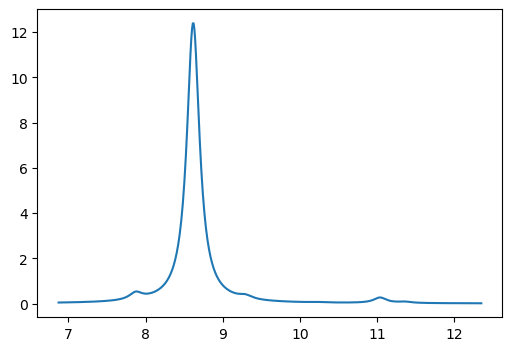

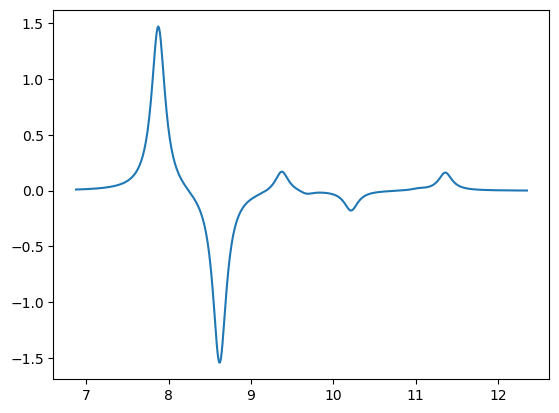

In [12]:
import matplotlib.pyplot as plt

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    '''
    Lorentzian broadening function
    
    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    '''
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

plt.figure(figsize=(6,4))

x = np.array(excitation_energies) * 27.211385
y_abs = np.array(oscillator_strengths)
y_ecd = np.array(rotatory_strengths)

x0,y0 = lorentzian(x, y_abs, min(x)-1.0, max(x)+1.0, 0.01, 0.2)
plt.plot(x0,y0)
plt.show()

x1,y1 = lorentzian(x, y_ecd, min(x)-1.0, max(x)+1.0, 0.01, 0.2)
plt.plot(x1,y1)
plt.show()

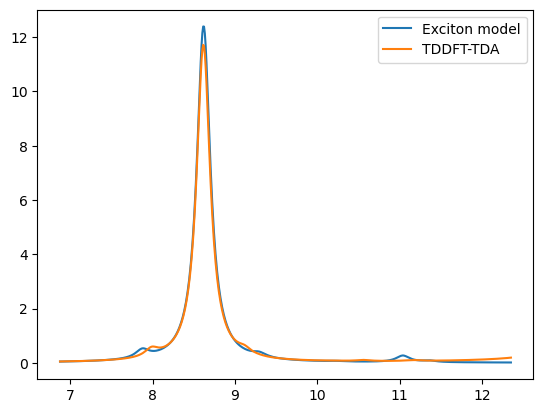

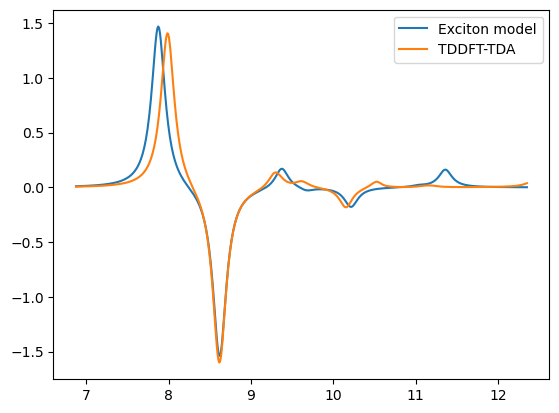

In [13]:
x_ref = 27.211385 * np.array([
    0.29347889, 0.31661749, 0.33498928, 0.33948716, 0.34142481, 0.34378921,
    0.35317567, 0.35467501, 0.37317654, 0.37523192, 0.38737236, 0.38809457,
    0.40824740, 0.41131899, 0.44405319, 0.44836638, 0.45442440, 0.45618961,
    0.45869117, 0.46343516, 0.46961985, 0.47008569, 0.48617428, 0.48913889,
    0.49490201, 0.49583015, 0.49623637, 0.50093006, 0.50196948, 0.50276614,
    0.54606024, 0.54653988, 0.54825489, 0.54984647, 0.55276288, 0.55355450,
    0.56052689, 0.56204114, 0.56307883, 0.56521540, 0.57830505, 0.57987938,
    0.58276149, 0.59040369, 0.59608911, 0.59657872, 0.60755394, 0.61502897,
    0.62056515, 0.62125169
])

y_abs_ref = np.array([
    0.0293, 1.1700, 0.0189, 0.0000, 0.0008, 0.0000, 0.0001, 0.0000, 0.0003,
    0.0004, 0.0004, 0.0036, 0.0011, 0.0024, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0003, 0.0076, 0.0000, 0.0000, 0.0042, 0.0170, 0.0268, 0.0055, 0.2073,
    0.7341, 0.7807, 0.8590, 0.0543, 0.0794, 0.0043, 0.0003, 0.0024, 0.1701,
    0.0002, 0.0001, 0.0005, 0.0000, 0.0190, 0.4825, 0.0609, 0.0002, 0.0031,
    0.0004, 0.2050, 0.0002, 0.0191, 0.0152
])

y_ecd_ref = np.array([
    0.144750, -0.164027, -0.000035, 0.000009, 0.014472, 0.001995, 0.004958,
    0.000899, -0.019302, 0.000786, 0.013440, -0.007686, 0.000918, 0.001135,
    -0.000005, -0.000019, 0.000222, 0.003878, 0.000392, -0.000790, -0.000002,
    0.000000, 0.006479, 0.047084, 0.458896, -0.154583, -0.063050, -0.217650,
    -0.459211, 0.383874, 0.041366, -0.032507, 0.000123, 0.000373, 0.025144,
    -0.050821, 0.000443, 0.003195, -0.001069, 0.000036, 0.285024, -0.269169,
    -0.004591, 0.000050, 0.005488, 0.001347, -0.000665, 0.000083, -0.023592,
    -0.011323
])

x0_ref,y0_ref = lorentzian(x_ref, y_abs_ref, min(x)-1.0, max(x)+1.0, 0.01, 0.2)
plt.plot(x0,y0,label='Exciton model')
plt.plot(x0_ref,y0_ref,label='TDDFT-TDA')
plt.legend()
plt.show()

x1_ref,y1_ref = lorentzian(x_ref, y_ecd_ref, min(x)-1.0, max(x)+1.0, 0.01, 0.2)
plt.plot(x1,y1,label='Exciton model')
plt.plot(x1_ref,y1_ref,label='TDDFT-TDA')
plt.legend()
plt.show()